In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, log_loss, accuracy_score

In [3]:
X_train = pd.read_pickle('train_set_final_filtered.pkl').drop(columns=['is_fraud'])
y_train = pd.read_pickle('train_set_final_filtered.pkl')['is_fraud']
    
X_test = pd.read_pickle('test_set_final_filtered.pkl').drop(columns=['is_fraud'])
y_test = pd.read_pickle('test_set_final_filtered.pkl')['is_fraud']
    


Running test data using best model and parameters

In [4]:
# Using the best set found: Set 2 (Max_Depth=8, Learning_Rate=0.05)
BEST_PARAMS = {
    'n_estimators': 150, 
    'max_depth': 6, 
    'learning_rate': 0.1, 
    'gamma': 0.5
}

In [5]:
imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()

final_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=imbalance_ratio,
    random_state=42,
    n_jobs=-1,
    **BEST_PARAMS 
)

print("\nTraining final XGBoost model on the full Training Set...")
final_xgb_model.fit(X_train, y_train)
print("✅ Final model training complete.")


Training final XGBoost model on the full Training Set...
✅ Final model training complete.


Evaluation on Test Set

In [6]:
print("\nEvaluating model on the unseen Testing Set...")

y_proba = final_xgb_model.predict_proba(X_test)[:, 1]
y_pred = final_xgb_model.predict(X_test)

final_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, zero_division=0),
    'Recall': recall_score(y_test, y_pred, zero_division=0),
    'F1-Score': f1_score(y_test, y_pred, zero_division=0),
    'Log-loss': log_loss(y_test, y_proba),
    'AUC': roc_auc_score(y_test, y_proba)
}

print("\n" + "="*70)
print("     FINAL XGBOOST MODEL PERFORMANCE (on Test Set)")
print("="*70)
print(f"Total Test Samples: {len(X_test):,}")

metrics_table = pd.DataFrame([final_metrics]).T.rename(columns={0: 'Value'})
print(metrics_table.to_markdown(floatfmt=".6f"))




Evaluating model on the unseen Testing Set...

     FINAL XGBOOST MODEL PERFORMANCE (on Test Set)
Total Test Samples: 302,092
|           |    Value |
|:----------|---------:|
| Accuracy  | 0.992996 |
| Precision | 0.434830 |
| Recall    | 0.984088 |
| F1-Score  | 0.603151 |
| Log-loss  | 0.021846 |
| AUC       | 0.997697 |


##SHAP Analasys

In [7]:
#!pip install shap

Calculating SHAP values... .
✅ SHAP values calculated.
Generating SHAP summary plot...
✅ SHAP summary plot saved as 'shap_summary_plot.png'.


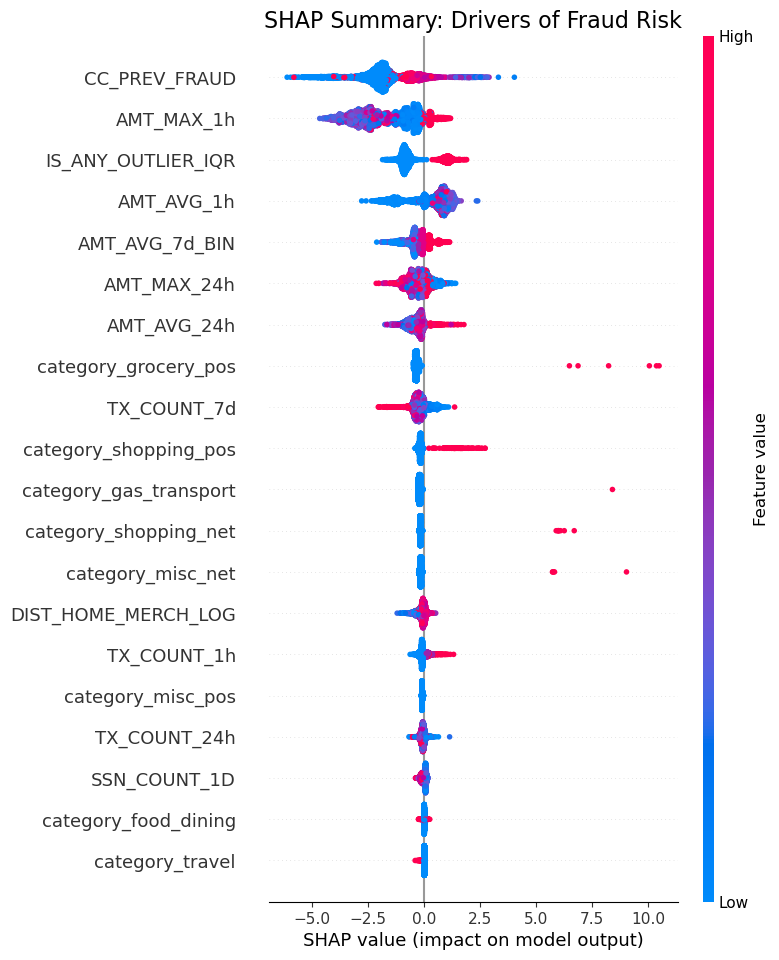

In [8]:
import matplotlib.pyplot as plt
import shap


print("Calculating SHAP values... .")

explainer = shap.TreeExplainer(final_xgb_model)

# use a representative sample (e.g., 5,000 rows) for the summary plot.
X_test_sample = shap.sample(X_test, nsamples=5000, random_state=42)
shap_values = explainer.shap_values(X_test_sample)

print("✅ SHAP values calculated.")

print("Generating SHAP summary plot...")


shap.summary_plot(
    shap_values, 
    X_test_sample, 
    plot_type="dot",
    show=False
)

# Save the plot for your presentation
plt.title("SHAP Summary: Drivers of Fraud Risk", fontsize=16)
plt.savefig("shap_summary_plot.png", bbox_inches='tight')
print("✅ SHAP summary plot saved as 'shap_summary_plot.png'.")

In [9]:
final_xgb_model.save_model("final_xgb_model_production.json")
print("\n Final production model saved as 'final_xgb_model_production.json'.")


 Final production model saved as 'final_xgb_model_production.json'.
